# Part B: RL
***

## Background Research

The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

The diagram below specifies the coordinate system used for the implementation of the pendulum’s dynamic equations.

Pendulum Coordinate System

x-y: cartesian coordinates of the pendulum’s end in meters.

theta : angle in radians.

tau: torque in N m. Defined as positive counter-clockwise

Reward Function: The reward function is defined as:

𝑟=−(𝜃^2+ 0.1⋅angular_velocity^2+ 0.001⋅torque^2)r=−(θ^2 + 0.1⋅ angular_velocity^2 + 0.001⋅torque^2 )


Action Space
The action is a ndarray with shape (1,) representing the torque applied to free end of the pendulum.

Num Action  Min  Max
0   Torque -2.0  2.0

This Pendulum Environment is a Continuous Action Space: The action can take any real value within the specified range, which in this case is from -2.0 to 2.0. This means the agent can apply any torque value within this range.

***

## Importing the neccessary libraries
***

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import time
import matplotlib.pyplot as plt
import imageio

### This Environment is a continuous action space, but upon our own research, DQN is better suited for discrete action spaces

Discrete Action Spaces:
Action Selection: DQN selects actions by evaluating the Q-values for each possible action and choosing the action with the highest Q-value. This works well when the number of actions is finite and discrete.
Action Representation: The output layer of a DQN typically has a node for each possible action, making it easy to handle discrete actions.

Continuous Action Spaces:
Challenges: In continuous action spaces, the action space is infinite and continuous, making it impractical to directly apply the same Q-value evaluation strategy as in discrete spaces.
Alternatives: For continuous action spaces, alternative algorithms like DDPG (Deep Deterministic Policy Gradient), TD3 (Twin Delayed DDPG), and PPO (Proximal Policy Optimization) are often used. These methods can handle continuous actions by directly parameterizing the policy or using actor-critic methods.
***

## DQN Class Initialization and Model Creation
#### The `DQN` class is designed for implementing a Deep Q-Network. It includes methods for creating the model, updating the replay memory, training the model, and applying the Gradient Tape for optimization. The class also handles the update of the target network.


#### Model Architecture

Network Structure: Design a neural network with an input layer corresponding to the observation space (3 features), hidden layers with a certain number of units (e.g., 64), and an output layer representing Q-values for possible actions.
Replay Memory: Store past experiences to break correlations and improve learning efficiency.
Target Network: Use a target network to stabilize the Q-value updates.
 
#### Training Strategy

Experience Replay: Sample batches of experiences from the replay memory to update the Q-network.
Epsilon-Greedy Policy: Implement an epsilon-greedy policy to balance exploration (trying new actions) and exploitation (choosing the best-known actions).


***

In [27]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 1,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32):
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        self.TargetUpdateCounter = 0
    
    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information):
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext
        
            X.append(S)
            Y.append(Q)
        
        self.GTfit(X, Y)
                
        if EndOfEpisode:
            self.TargetUpdateCounter += 1
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0
    
    @tf.function
    def GTfit(self, X, Y):
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))


### Helper Functions and Defining the Environment

#### Here, we define helper functions to convert actions between the action space and the actual torque applied to the pendulum. These functions also handle the simulation of one episode.

***
### Pendulum Environment Class Definition

This cell defines the `PendulumEnv` class. Key components include:

1. **Initialization (`__init__` method)**:
    - Instantiates the environment using `gym.make`.
    - Sets the number of discrete actions (`NActions`) for the environment.

2. **Action Conversion Methods (`PendulumActionConverter` and `PendulumInverseActionConverter`)**:
    - Converts between discrete actions and the continuous action space of the Pendulum environment.
    - `PendulumActionConverter` maps discrete actions to the corresponding torque values.
    - `PendulumInverseActionConverter` maps torque values back to discrete actions.

These methods facilitate the interaction between the DDPG agent and the continuous action space of the Pendulum environment.
***

In [28]:
class PendulumEnv:
    def __init__(self, EnvName='Pendulum-v0', NActions=40):
        self.env = gym.make(EnvName)
        self.NActions = NActions
    
    def PendulumActionConverter(self, A):
        ActualTorque = (A / self.NActions - 0.5) * 4
        return ActualTorque
    
    def PendulumInverseActionConverter(self, A):
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return ActualA
    
    def OneEpisode(self, DQN, Epsilon, ShowEvery, episode):
        S = self.env.reset()
        ListOfRewards = []
        QValues = []  # Track Q-values for each step
        Done = False
        while not Done:
            Q = DQN.Main(S.reshape(-1, S.shape[0])).numpy()  # Convert tensor to numpy array
            QValues.append(Q.flatten())  # Save Q-values
            
            if np.random.rand() < Epsilon:
                AStep = self.env.action_space.sample()
                A = self.PendulumInverseActionConverter(AStep[0])
            else:
                A = np.argmax(Q)
                A = self.PendulumActionConverter(A)
                AStep = np.array([A])
                A = self.PendulumInverseActionConverter(A)
        
            if not episode % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
                self.env.render()
            
            SNext, R, Done, Info = self.env.step(AStep)
            DQN.UpdateReplayMemory((S, A, R, SNext, Done))
            DQN.Train(Done)
            ListOfRewards.append(R)
            
            if Done:
                self.env.close()
                TotalReward = np.sum(ListOfRewards)
                print(f'Episode {episode} finished with total reward: {TotalReward}')
                return TotalReward, QValues  # Return Q-values along with reward
            S = SNext


### Initialize and training The DQN model

#### In this section, we initialize the DQN model and run training for a number of episodes. We also keep track of the total time taken for the training process.

***

### Evaluation of DQN model

#### Q-Value Distribution

The Q-value distribution graph illustrates the frequency of different Q-values predicted by the model. This distribution helps assess how the model's Q-values are spread out. A well-distributed set of Q-values indicates a balanced exploration of actions, whereas a skewed distribution might suggest a preference for specific actions. Monitoring this distribution helps in understanding the quality and behavior of the model's policy.
***

#### Moving Average of Rewards

The moving average of rewards graph smooths out short-term fluctuations to highlight trends in the model's performance. By averaging rewards over a window (e.g., 50 episodes), it helps to observe performance improvements or stability issues. A rising moving average suggests effective learning and improving performance, while a flat or declining trend may indicate problems in the model's training.


In [29]:
def TrainDQN(episodes=200, epsilon=0.1, show_every=10, input_shape=3, n_actions=40, env_name='Pendulum-v0'):
    STARTTIME = time.time()
    dqn = DQN(InputShape=input_shape, NActions=n_actions)
    env = PendulumEnv(env_name, n_actions)
    
    Rewards = []
    all_q_values = []
    moving_avg_rewards = []
    learning_speeds = []  # To track learning speed

    for episode in range(episodes):
        print(f'Episode {episode}')
        EpisodeReward, episode_q_values = env.OneEpisode(dqn, epsilon, show_every, episode)
        Rewards.append(EpisodeReward)
        all_q_values.extend([np.mean(qv) for qv in episode_q_values])  # Track mean Q-values
        
        # Calculate moving average of rewards
        if episode >= 10:
            moving_avg = np.mean(Rewards[-10:])
            moving_avg_rewards.append(moving_avg)
        
        # Optionally track learning speed as difference between consecutive rewards
        if episode >= 1:
            learning_speed = Rewards[-1] - Rewards[-2]
            learning_speeds.append(learning_speed)

    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

    # Plotting evaluation metrics
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color='tab:blue')
    ax1.plot(Rewards, color='tab:blue', label='Total Reward')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    plt.title('Total DQN Rewards per Episode')
    plt.show()

    # Plot Q-Value Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(all_q_values, bins=50, alpha=0.7, color='g')
    plt.xlabel('Q-Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Q-Values (DQN)')
    plt.grid()
    plt.show()

    # Plot Moving Average of Rewards
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window_size = 20
    ma_rewards = moving_average(Rewards, window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(ma_rewards, label=f'{window_size}-Episode Moving Average', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title(f'{window_size}-Episode Moving Average of Reward (DQN)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Learning Speed
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(learning_speeds) + 1), learning_speeds, color='r', label='Learning Speed')
    plt.xlabel('Episode')
    plt.ylabel('Learning Speed (Reward Difference)')
    plt.title('Learning Speed per Episode')
    plt.legend()
    plt.grid()
    plt.show()

    return Rewards, learning_speeds



### Running the Training

Execute the `train_DQN` function to start training the improved DQN model on the Pendulum environment.


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7,016
Trainable params: 7,016
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]    

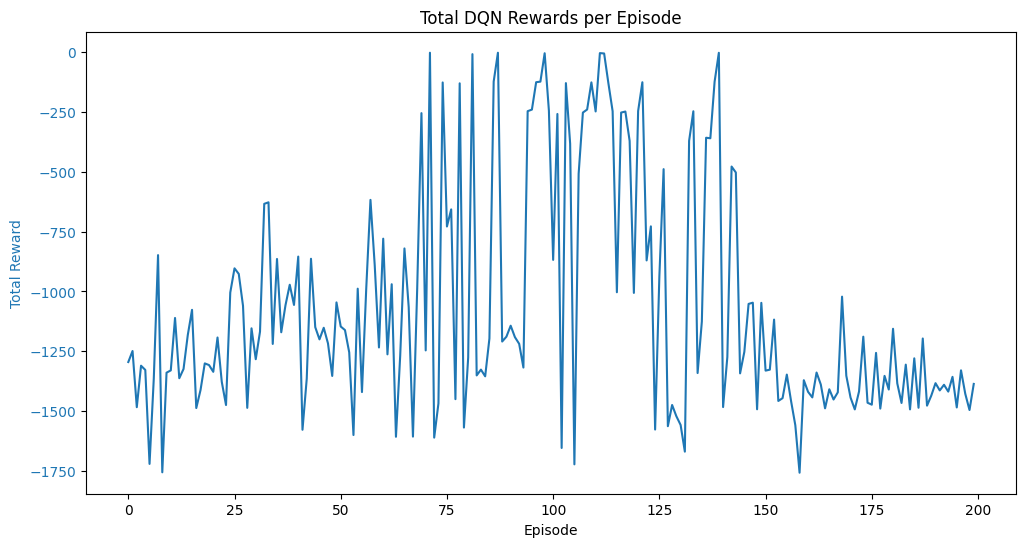

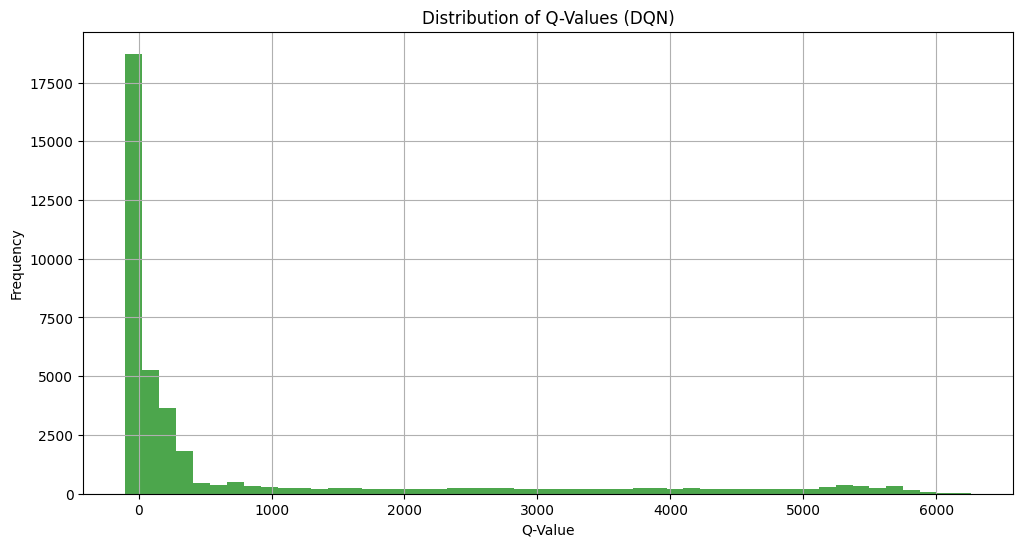

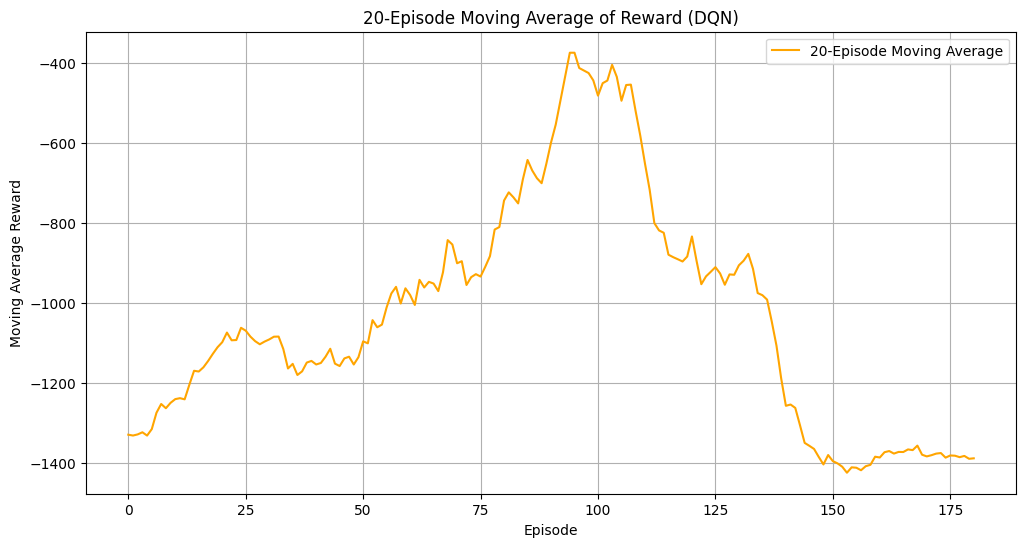

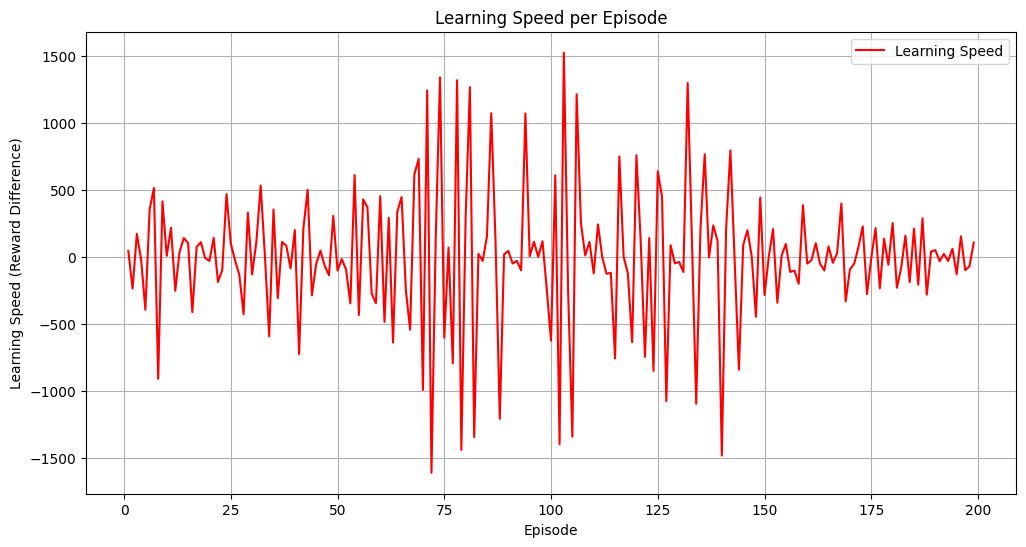

In [30]:
# Execute training and plot results
rewards, learning_speeds = TrainDQN()

## DQN Model Improvement 

***

### `Improved_DQN` Class Summary

The `Improved_DQN` class is an implementation of the Deep Q-Network (DQN) algorithm with several enhancements for better performance. Key components include:

- **Initialization Parameters**:
  - **InputShape**: Shape of the input state.
  - **NActions**: Number of possible actions.
  - **Gamma**: Discount factor for future rewards.
  - **ReplayMemorySize**: Size of the replay memory.
  - **MinReplayMemory**: Minimum number of transitions required in replay memory before training starts.
  - **UpdateTargetEveryThisEpisodes**: Frequency to update the target network.
  - **IntermediateSize**: Size of the hidden layers.
  - **BatchSize**: Number of samples per batch.
  - **Alpha, BetaStart, BetaFrames**: Parameters for prioritized experience replay.
  - **InitialLearningRate, LearningRateDecay, DecaySteps**: Parameters for the learning rate schedule.

- **Model Creation**:
  - **CreateModel**: Builds the neural network model for both the main and target networks.

- **Replay Memory**:
  - Uses a prioritized experience replay buffer to store and sample transitions.
  - **UpdateReplayMemory**: Adds transitions to the replay memory with a priority based on the TD-error.

- **Training Process**:
  - **SampleBatch**: Samples a batch of transitions from the replay memory.
  - **Train**: Trains the DQN by updating the main network and periodically syncing the target network.
  - **GTfit**: Uses gradient tape to compute gradients and apply them to update the main network.

- **Enhanced Features**:
  - **Experience Replay**: 
To learn from previous Episodes

  - **Learning Rate Schedule**: Adjusts the learning rate over time using an exponential decay schedule.
  - **Epsilon Decay**: Gradually decreases the exploration rate to balance exploration and exploitation.

This class provides a robust implementation of the DQN algorithm, leveraging advanced techniques like prioritized experience replay and adaptive learning rates to enhance training performance and stability.


In [2]:
class Improved_DQN:
    def __init__(self,
                 InputShape=4,
                 NActions=2,
                 Gamma=1,
                 ReplayMemorySize=10000,
                 MinReplayMemory=1000,
                 UpdateTargetEveryThisEpisodes=1,
                 IntermediateSize=64,
                 BatchSize=32,
                 Alpha=0.6,  # For prioritized experience replay
                 BetaStart=0.4,  # For prioritized experience replay
                 BetaFrames=100000,  # For prioritized experience replay
                 initial_epsilon=1.0,  # Epsilon for exploration
                 min_epsilon=0.1,      # Minimum epsilon
                 epsilon_decay=0.995): # Epsilon decay factor
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        self.ReplayMemory = deque(maxlen=ReplayMemorySize)
        self.Priorities = tf.Variable(np.zeros(ReplayMemorySize), dtype=tf.float32)
        self.TargetUpdateCounter = 0
        self.Alpha = Alpha
        self.BetaStart = BetaStart
        self.BetaFrames = BetaFrames
        self.Frame = 1

        # Initialize epsilon parameters
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay

    def CreateModel(self, Type):
        inputs = Input(shape=(self.InputShape), name='Input')
        x = Dense(self.IntermediateSize, activation='relu', name='1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation='relu', name='2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation='linear', name='Output')(x)
        
        NN = Model(inputs, outputs, name=f'{Type}')
        NN.summary()
        
        return NN

    def UpdateReplayMemory(self, Information, TD_Error):
        self.ReplayMemory.append(Information)
        idx = len(self.ReplayMemory) - 1
        self.Priorities[idx].assign((abs(TD_Error) + 1e-5) ** self.Alpha)

    def SampleBatch(self):
        priorities = np.array(self.Priorities[:len(self.ReplayMemory)])
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.ReplayMemory), self.BatchSize, p=probabilities)
        samples = [self.ReplayMemory[idx] for idx in indices]
        return samples, indices, probabilities[indices]
    
    def Train(self, EndOfEpisode):
        if len(self.ReplayMemory) < self.MinReplayMemory:
            return
        
        TrainingData, indices, sample_probs = self.SampleBatch()
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        X, Y, TD_Errors = [], [], []
        for idx, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[idx])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[idx]
            TD_Error = QNext - Q[A]
            TD_Errors.append(TD_Error)
            Q[A] = QNext
            X.append(S)
            Y.append(Q)
        
        self.GTfit(X, Y, indices, sample_probs, TD_Errors)
        
        if EndOfEpisode:
            self.TargetUpdateCounter += 1
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0

    @tf.function
    def GTfit(self, X, Y, indices, sample_probs, TD_Errors):
        # Convert sample_probs directly to tf.float32 tensor
        sample_probs = tf.convert_to_tensor(sample_probs, dtype=tf.float32)
        
        # Compute weights using TensorFlow operations
        weights = (len(self.ReplayMemory) * sample_probs) ** (-self.BetaStart)
        weights /= tf.reduce_max(weights)
        weights = tf.convert_to_tensor(weights, dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Ensure X and Y are converted to tensors
            Predictions = self.Main(tf.convert_to_tensor(X), training=True)
            Loss = tf.reduce_mean(weights * tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions), axis=1))

        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

        # Update priorities using TensorFlow operations
        indices = tf.convert_to_tensor(indices, dtype=tf.int32)
        TD_Errors = tf.convert_to_tensor(TD_Errors, dtype=tf.float32)
        updated_priorities = (tf.abs(TD_Errors) + 1e-5) ** self.Alpha

        # Use TensorFlow's scatter update to update the priorities
        self.Priorities.scatter_update(tf.IndexedSlices(updated_priorities, indices))

        self.BetaStart = min(1.0, self.BetaStart + self.Frame / self.BetaFrames)
        self.Frame += 1

    def act(self, state):
        # Choose action based on epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            # Random action
            return np.random.randint(self.NActions)
        else:
            # Greedy action
            state = np.expand_dims(state, axis=0)  # Add batch dimension
            q_values = self.Main(state)
            return np.argmax(q_values[0])  # Get action with max Q-value
        
    def save_weights(self, filepath):
        self.Main.save_weights(filepath)

    def load_weights(self, filepath):
        self.Main.load_weights(filepath)

### `PendulumEnv` Class Summary

The `PendulumEnv` class is a custom wrapper for the OpenAI Gym Pendulum-v0 environment, tailored for training reinforcement learning agents with discrete actions. Key components include:

- **Initialization Parameters**:
  - **EnvName**: Name of the environment.
  - **NActions**: Number of discrete actions.
  - **reward_range**: Range for normalizing rewards.

- **Action Conversion**:
  - **PendulumActionConverter**: Converts discrete actions to continuous torque values for the pendulum.
  - **PendulumInverseActionConverter**: Converts continuous torque values back to discrete actions.

- **Reward Normalization**:
  - **NormalizeReward**: Normalizes the reward to fall within the specified reward range.

- **Episode Execution**:
  - **OneEpisode**: Runs one episode of the environment using the given DQN agent. Key steps include:
    - Resetting the environment and initializing variables.
    - Choosing actions based on an epsilon-greedy policy.
    - Converting actions between discrete and continuous representations.
    - Rendering the environment if specified.
    - Stepping through the environment and collecting rewards.
    - Updating the replay memory with transitions and training the DQN agent.
    - Printing the total reward at the end of the episode.

This class facilitates the training of DQN agents on the Pendulum-v0 environment by discretizing actions and normalizing rewards, enhancing compatibility and performance.


In [3]:
class PendulumEnv:
    def __init__(self, EnvName='Pendulum-v0', NActions=40, reward_range=(-1, 1)):
        self.env = gym.make(EnvName)
        self.NActions = NActions
        self.reward_range = reward_range
    
    def PendulumActionConverter(self, A):
        # Convert discrete action to continuous torque
        ActualTorque = (A / self.NActions - 0.5) * 4
        return ActualTorque
    
    def PendulumInverseActionConverter(self, A):
        # Convert continuous torque to discrete action
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return ActualA
    
    def NormalizeReward(self, reward):
        # Normalize reward within the specified range
        min_r, max_r = self.reward_range
        normalized = (reward - min_r) / (max_r - min_r)
        return normalized
    
    def OneEpisode(self, DQN, Epsilon, ShowEvery, episode):
        # Run one episode of the environment
        S = self.env.reset()
        ListOfRewards = []
        episode_q_values = []
        Done = False
        
        while not Done:
            Q = DQN.Main(S.reshape(-1, S.shape[0]))
            episode_q_values.append(np.max(Q))  # Collect Q-values
            
            if np.random.rand() < Epsilon:
                AStep = self.env.action_space.sample()
                A = self.PendulumInverseActionConverter(AStep[0])
            else:
                A = np.argmax(Q)
                A = self.PendulumActionConverter(A)
                AStep = np.array([A])
                A = self.PendulumInverseActionConverter(A)
            
            if not episode % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
                self.env.render()
            
            SNext, R, Done, Info = self.env.step(AStep)
            R = self.NormalizeReward(R)
            TD_Error = R + DQN.Gamma * np.max(DQN.Target(SNext.reshape(-1, SNext.shape[0]))) - np.max(Q)
            DQN.UpdateReplayMemory((S, A, R, SNext, Done), TD_Error)
            DQN.Train(Done)
            ListOfRewards.append(R)
            S = SNext
        
        self.env.close()
        TotalReward = np.sum(ListOfRewards)
        print(f'Episode {episode} finished with total reward: {TotalReward}')
        return TotalReward, episode_q_values

### `TrainDQN` Function Summary

The `TrainDQN` function trains an Improved Deep Q-Network (DQN) on the OpenAI Gym Pendulum-v0 environment. Key components and steps include:

- **Initialization Parameters**:
  - **episodes**: Total number of episodes for training.
  - **initial_epsilon**: Starting value for epsilon in epsilon-greedy policy.
  - **min_epsilon**: Minimum value for epsilon.
  - **epsilon_decay**: Decay rate for epsilon.
  - **show_every**: Frequency of rendering the environment.
  - **input_shape**: Shape of the input state.
  - **n_actions**: Number of discrete actions.
  - **env_name**: Name of the environment.
  - **save_gif**: Boolean flag to save the final episode as a GIF.

- **Initialization**:
  - Creates instances of `Improved_DQN` and `PendulumEnv`.
  - Initializes tracking variables for rewards, epsilon, best reward, learning speeds, stability scores, epsilons, and Q-values.
  - Optionally prepares a list to store frames for GIF creation.

- **Training Process**:
  - Iterates through the specified number of episodes.
  - Runs one episode using the `OneEpisode` method from `PendulumEnv`.
  - Updates rewards, Q-values, and epsilons.
  - Adjusts epsilon based on the best reward achieved.
  - Calculates stability scores as running variance over the last 10 episodes.
  - Measures learning speed as time taken per episode.
  - Captures frames for the final episode if `save_gif` is enabled.

- **Post-Training**:
  - Prints the total time taken for training.
  - Saves the final episode as a GIF if required.
  - Plots evaluation metrics:
    - Total rewards and stability scores per episode.
    - Epsilon decay over time.
    - Distribution of Q-values.
    - Moving average of rewards over a specified window size.

This function provides a comprehensive training loop for the Improved DQN agent, with detailed tracking and visualization of training progress and performance.


In [4]:
def TrainDQN(episodes=200, initial_epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.995, show_every=10, input_shape=3, n_actions=40, env_name='Pendulum-v0', save_gif=False, save_weights_path='dqn_weights.h5'):
    STARTTIME = time.time()
    dqn = Improved_DQN(InputShape=input_shape, NActions=n_actions, initial_epsilon=initial_epsilon, min_epsilon=min_epsilon, epsilon_decay=epsilon_decay)
    env = PendulumEnv(env_name, n_actions)
    
    Rewards = []
    epsilon = initial_epsilon
    best_reward = float('-inf')
    learning_speeds = []
    epsilons = []
    q_values = []
    
    frames = []  # List to store frames for GIF

    prev_reward = None  # For calculating reward difference

    for episode in range(episodes):
        print(f'Episode {episode}')
        EpisodeReward, episode_q_values = env.OneEpisode(dqn, epsilon, show_every, episode)
        Rewards.append(EpisodeReward)
        q_values.extend(episode_q_values)
        epsilons.append(epsilon)
        
        # Measure learning speed: Check if the best reward is achieved
        if EpisodeReward > best_reward:
            best_reward = EpisodeReward
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
        # Track learning speed by measuring reward difference per episode
        if prev_reward is not None:
            reward_diff = EpisodeReward - prev_reward
            learning_speeds.append(reward_diff)
        else:
            learning_speeds.append(0)  # No difference for the first episode
        
        prev_reward = EpisodeReward


        # Capture frames for the last 50 episodes if saving GIF
        if save_gif and episode >= episodes - 50:
            state = env.env.reset()
            done = False
            while not done:
                frames.append(env.env.render(mode='rgb_array'))  # Capture frame
                action = dqn.act(state)  # Use the `act` method
                actual_action = env.PendulumActionConverter(action)
                state, _, done, _ = env.env.step([actual_action])
    
    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')
    
    # Save GIF if required
    if save_gif:
        with imageio.get_writer('Improved_DQN_pendulum_last_50_episodes.gif', mode='I', duration=0.05) as writer:
            for frame in frames:
                writer.append_data(frame)
    
    # Save model weights
    dqn.save_weights(save_weights_path)
    
    # Plot Rewards per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(Rewards, color='b', label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Learning Speed (Reward Difference) per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(learning_speeds) + 1), learning_speeds, color='r', label='Learning Speed')
    plt.xlabel('Episode')
    plt.ylabel('Learning Speed (Reward Difference)')
    plt.title('Learning Speed per Episode')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Epsilon Decay Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(epsilons, label='Epsilon Decay', color='m')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Q-Value Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(q_values, bins=50, alpha=0.7, color='g')
    plt.xlabel('Q-Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Q-Values')
    plt.grid()
    plt.show()

    # Plot Moving Average of Rewards
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window_size = 20
    ma_rewards = moving_average(Rewards, window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(ma_rewards, label=f'{window_size}-Episode Moving Average', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title(f'{window_size}-Episode Moving Average of Reward')
    plt.legend()
    plt.grid()
    plt.show()

    return Rewards, learning_speeds



### Running the Training

Execute the `train_DQN` function to start training the improved DQN model on the Pendulum environment.
***

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7,016
Trainable params: 7,016
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]    

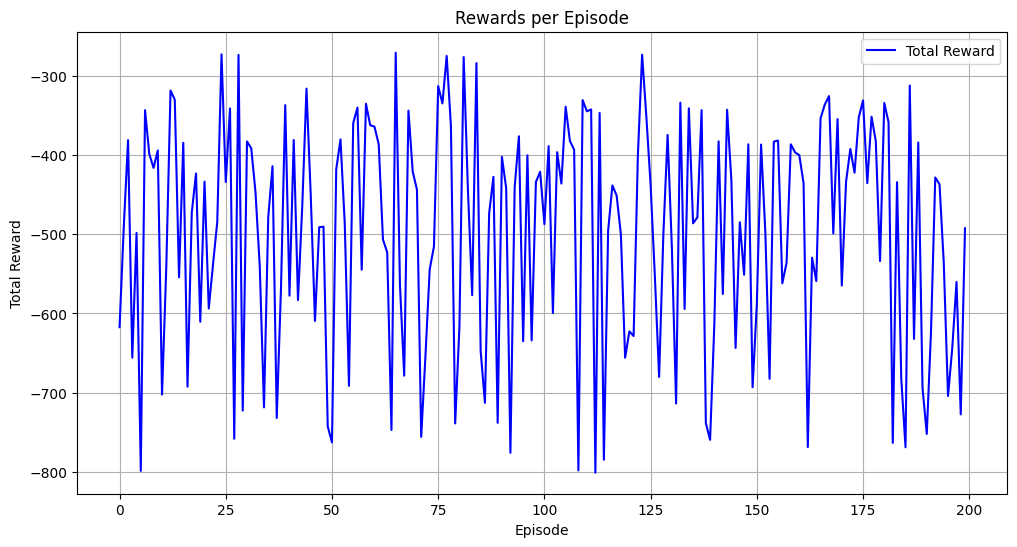

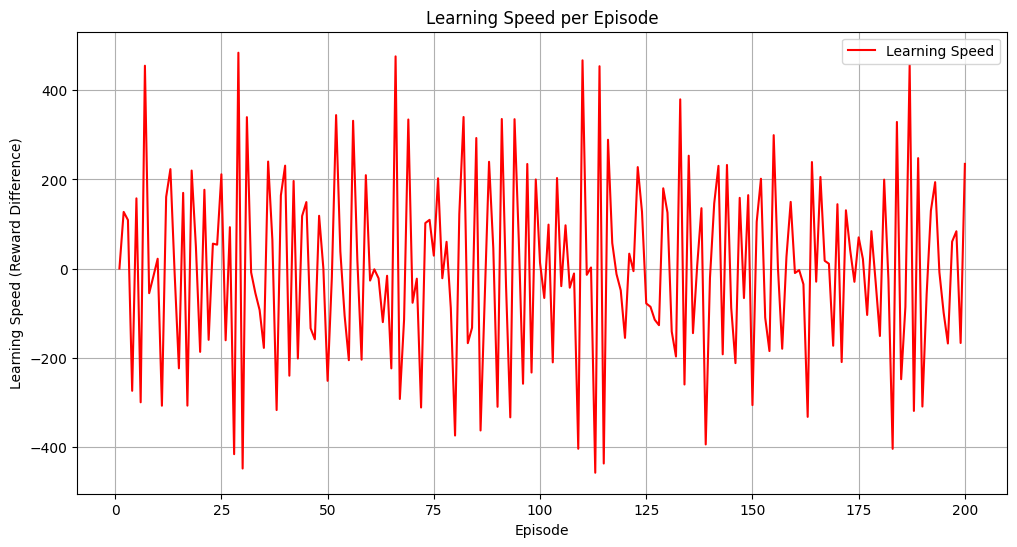

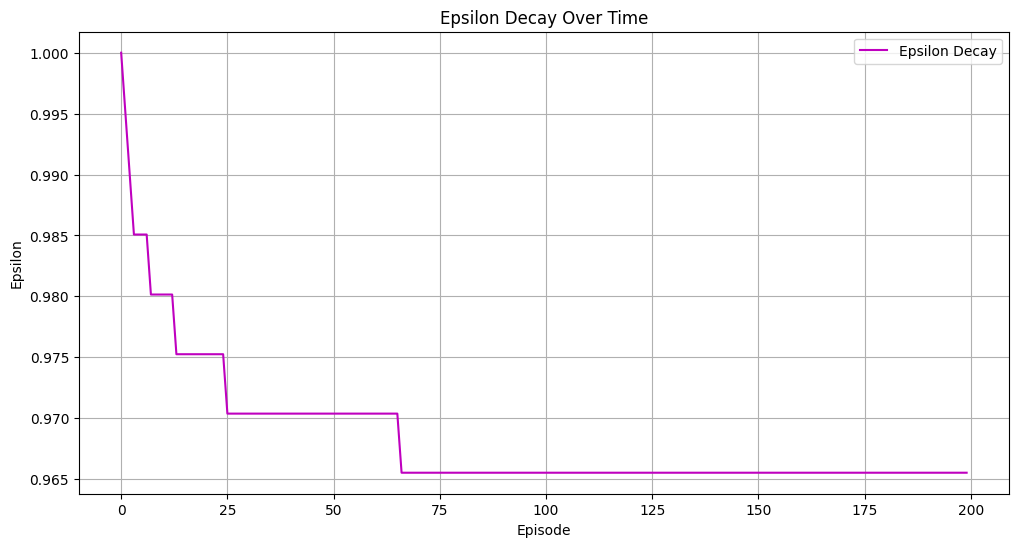

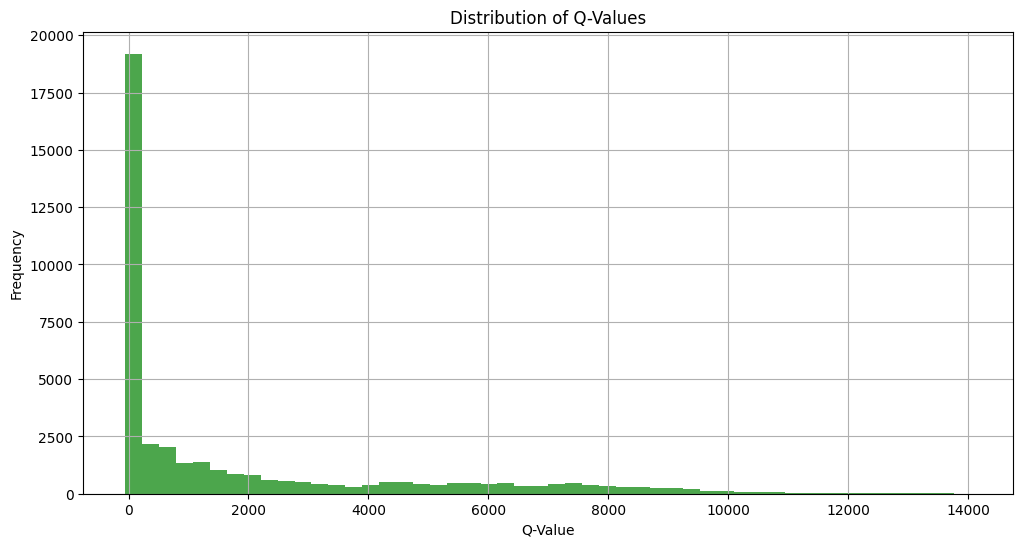

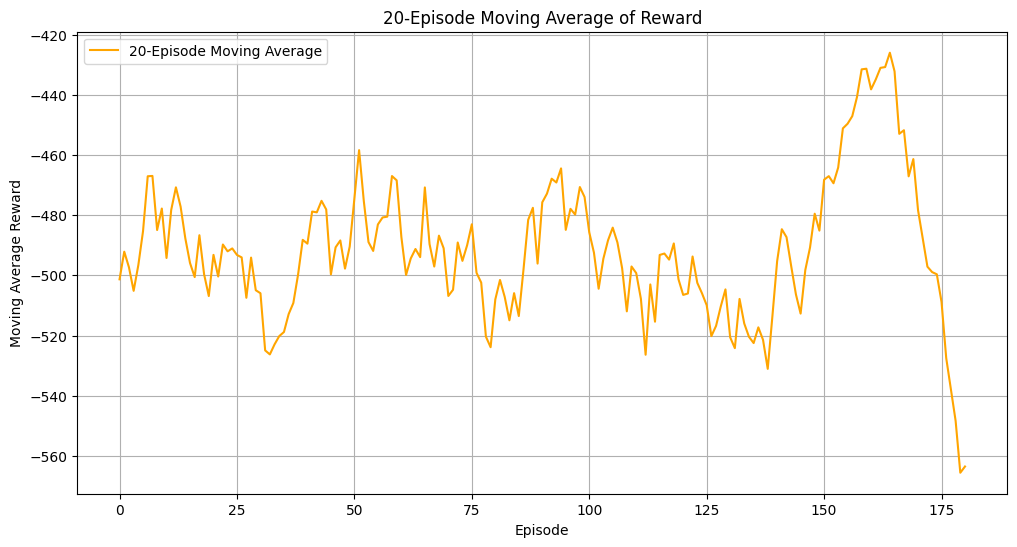

In [5]:
# Execute training and plot results
rewards, learning_speeds = TrainDQN(save_gif=True)



## `PPO` Class Summary

### Since this environment is a continuous action space, we have decided to use this model that is better suited for this environment
The `PPO` class implements the Proximal Policy Optimization (PPO) algorithm. Key components and methods include:

- **Initialization Parameters**:
  - **state_shape**: Shape of the input state.
  - **n_actions**: Number of discrete actions.
  - **gamma**: Discount factor for future rewards.
  - **epsilon**: Clipping parameter for PPO.
  - **lr**: Learning rate for the optimizers.

- **Networks**:
  - **Policy Network**: A neural network to predict action probabilities.
  - **Value Network**: A neural network to estimate state values.
  - Both networks have two hidden layers with 64 neurons each and ReLU activations.

- **Methods**:
  - **build_model**: Constructs the policy network.
  - **build_value_model**: Constructs the value network.
  - **act**: Selects an action based on the policy network's output probabilities.
  - **compute_advantages**: Computes Generalized Advantage Estimation (GAE) to reduce variance in policy gradient updates.
  - **update**: Updates the policy and value networks using collected experiences.

- **Policy Network Update**:
  - Computes the probability ratio of new and old policies.
  - Clips the probability ratio to prevent large updates.
  - Minimizes the clipped objective to update the policy network.

- **Value Network Update**:
  - Computes the value loss as the mean squared error between predicted and actual returns.
  - Minimizes the value loss to update the value network.

This class encapsulates the PPO algorithm's core logic, including action selection, advantage calculation, and network updates.


In [2]:
class PPO:
    def __init__(self, state_shape, n_actions, gamma=0.99, epsilon=0.2, lr=0.001):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        
        # Policy Network
        self.policy_model = self.build_model()
        self.policy_optimizer = Adam(learning_rate=self.lr)
        
        # Value Network
        self.value_model = self.build_value_model()
        self.value_optimizer = Adam(learning_rate=self.lr)
        
        # Track learning speed
        self.prev_total_reward = None
        self.learning_speeds = []

    def build_model(self):
        state_input = Input(shape=(self.state_shape,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.n_actions, activation='softmax')(x)
        model = Model(inputs=state_input, outputs=output)
        return model
    
    def build_value_model(self):
        state_input = Input(shape=(self.state_shape,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        output = Dense(1, activation='linear')(x)
        model = Model(inputs=state_input, outputs=output)
        return model
    
    def act(self, state):
        state = np.expand_dims(state, axis=0)
        prob = self.policy_model.predict(state)[0]
        return np.random.choice(self.n_actions, p=prob)
    
    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + (1 - dones[t]) * self.gamma * next_values[t] - values[t]
            gae = delta + (1 - dones[t]) * self.gamma * self.epsilon * gae
            advantages[t] = gae
        return advantages
    
    def update(self, states, actions, rewards, next_states, dones):
        values = self.value_model.predict(states)
        next_values = self.value_model.predict(next_states)
        
        advantages = self.compute_advantages(rewards, values, next_values, dones)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = advantages + values.flatten()

        # Update Policy Network
        with tf.GradientTape() as tape:
            probs = self.policy_model(states, training=True)
            actions_one_hot = tf.keras.utils.to_categorical(actions, self.n_actions)
            ratio = tf.reduce_sum(probs * actions_one_hot, axis=1) / tf.reduce_sum(self.policy_model(states) * actions_one_hot, axis=1)
            clipped_ratio = tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon)
            policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        
        policy_grads = tape.gradient(policy_loss, self.policy_model.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_model.trainable_variables))
        
        # Update Value Network
        with tf.GradientTape() as tape:
            value_preds = self.value_model(states)
            value_loss = tf.reduce_mean(tf.square(returns - value_preds))
        
        value_grads = tape.gradient(value_loss, self.value_model.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_model.trainable_variables))
        
        # Track learning speed
        if self.prev_total_reward is not None:
            reward_diff = np.sum(rewards) - self.prev_total_reward
            self.learning_speeds.append(reward_diff)
        else:
            self.learning_speeds.append(0)  # No difference for the first episode
        
        self.prev_total_reward = np.sum(rewards)
        
        return values  # Return values to track Q-values


### `PendulumEnv` Class Summary

The `PendulumEnv` class manages the Pendulum environment for training reinforcement learning agents, specifically designed for the Deep Q-Network (DQN) algorithm.

**Key Components and Methods**:

- **Initialization**:
  - **EnvName**: Name of the environment (default: `'Pendulum-v0'`).
  - **NActions**: Number of discrete actions.

- **Action Conversion Methods**:
  - **PendulumActionConverter**: Converts a discrete action to a continuous torque.
  - **PendulumInverseActionConverter**: Converts a continuous torque back to a discrete action.

- **OneEpisode**:
  - Runs a single episode in the environment.
  - Initializes the environment and state.
  - Chooses actions using epsilon-greedy strategy:
    - With probability `Epsilon`, selects a random action.
    - Otherwise, selects the action with the highest Q-value.
  - Converts actions using the action conversion methods.
  - Renders the environment every `ShowEvery` episodes if the replay memory has enough samples.
  - Collects rewards and Q-values at each step.
  - Updates replay memory and trains the DQN.
  - Returns the total reward and Q-values for the episode.

The class handles interaction with the environment, action conversion, and manages the running of episodes, integrating with the DQN for learning.


In [3]:
class PendulumEnv:
    def __init__(self, EnvName='Pendulum-v0', NActions=40):
        self.env = gym.make(EnvName)
        self.NActions = NActions
    
    def PendulumActionConverter(self, A):
        ActualTorque = (A / self.NActions - 0.5) * 4
        return ActualTorque
    
    def PendulumInverseActionConverter(self, A):
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return ActualA
    
    def OneEpisode(self, DQN, Epsilon, ShowEvery, episode):
        S = self.env.reset()
        ListOfRewards = []
        QValues = []  # Track Q-values for each step
        Done = False
        while not Done:
            Q = DQN.Main(S.reshape(-1, S.shape[0])).numpy()  # Convert tensor to numpy array
            QValues.append(Q.flatten())  # Save Q-values
            
            if np.random.rand() < Epsilon:
                AStep = self.env.action_space.sample()
                A = self.PendulumInverseActionConverter(AStep[0])
            else:
                A = np.argmax(Q)
                A = self.PendulumActionConverter(A)
                AStep = np.array([A])
                A = self.PendulumInverseActionConverter(A)
        
            if not episode % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
                self.env.render()
            
            SNext, R, Done, Info = self.env.step(AStep)
            DQN.UpdateReplayMemory((S, A, R, SNext, Done))
            DQN.Train(Done)
            ListOfRewards.append(R)
            
            if Done:
                self.env.close()
                TotalReward = np.sum(ListOfRewards)
                print(f'Episode {episode} finished with total reward: {TotalReward}')
                return TotalReward, QValues  # Return Q-values along with reward
            S = SNext

### Training Function

The `train_ppo` function trains the PPO model on the Pendulum environment. It includes the following steps:

- **Initialize Environment and PPO**: Creates the Pendulum environment and initializes the PPO model.
- **Experience Collection**: Gathers experiences by interacting with the environment.
- **Network Update**: Uses the collected experiences to update the policy and value networks.
- **Evaluation Metrics**: Calculates and plots evaluation metrics, including total rewards, Q-value distribution, and moving average of rewards.


In [4]:
def train_ppo(env_name='Pendulum-v0', episodes=200, batch_size=64, show_every=10):
    env = PendulumEnv(env_name)
    ppo = PPO(state_shape=env.env.observation_space.shape[0], n_actions=env.NActions)
    
    Rewards = []
    moving_avg_rewards = []
    epsilons = []
    learning_speeds = []
    all_q_values = []  # To store Q-values

    for episode in range(episodes):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        state = env.env.reset()
        done = False
        while not done:
            action = ppo.act(state)
            actual_action = env.PendulumActionConverter(action)
            next_state, reward, done, _ = env.env.step([actual_action])
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            state = next_state
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)
        
        q_values = ppo.update(states, actions, rewards, next_states, dones)
        all_q_values.extend(q_values.flatten())  # Collect Q-values
        
        total_reward = np.sum(rewards)
        Rewards.append(total_reward)
        learning_speeds = ppo.learning_speeds

        # Print reward for the current episode
        print(f'Episode {episode+1} total reward: {total_reward}')
        
        # Calculate moving average of rewards
        if episode >= 10:
            moving_avg = np.mean(Rewards[-10:])
            moving_avg_rewards.append(moving_avg)
        
        # Track epsilon decay
        epsilons.append(ppo.epsilon)
        
        # Render the environment every `show_every` episodes
        if (episode + 1) % show_every == 0:
            env.env.render()
            print(f'Episode {episode+1} completed with total reward: {total_reward}')
            env.env.close()

    # Final environment rendering
    env.env.render()
    env.env.close()
    
    print(f'Total time taken: {time.time() - STARTTIME} seconds ...')
    
    # Plot Rewards per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(Rewards, color='b', label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode (PPO)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Learning Speed (Reward Difference) per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(learning_speeds) + 1), learning_speeds, color='r', label='Learning Speed')
    plt.xlabel('Episode')
    plt.ylabel('Learning Speed (Reward Difference)')
    plt.title('Learning Speed per Episode (PPO)')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Q-Value Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(all_q_values, bins=50, alpha=0.7, color='g')
    plt.xlabel('Q-Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Q-Values (PPO)')
    plt.grid()
    plt.show()

    # Plot Moving Average of Rewards
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window_size = 20
    ma_rewards = moving_average(Rewards, window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(ma_rewards, label=f'{window_size}-Episode Moving Average', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title(f'{window_size}-Episode Moving Average of Reward (PPO)')
    plt.legend()
    plt.grid()
    plt.show()
    
    return Rewards, learning_speeds, all_q_values


### Running the Training

Execute the `train_ppo` function to start training the PPO model on the Pendulum environment.
***

7/7 [==============================] - 0s 2ms/step
Episode 1 total reward: -1003.7888597979512
7/7 [==============================] - 0s 954us/step
Episode 2 total reward: -1289.7367591494676
7/7 [==============================] - 0s 3ms/step
Episode 3 total reward: -1397.9519212437476
7/7 [==============================] - 0s 1ms/step
Episode 4 total reward: -1062.8232318684736
7/7 [==============================] - 0s 1ms/step
Episode 5 total reward: -1626.9296843294728
7/7 [==============================] - 0s 980us/step
Episode 6 total reward: -1162.4544153499405
7/7 [==============================] - 0s 336us/step
Episode 7 total reward: -761.9369840363465
7/7 [==============================] - 0s 1ms/step
Episode 8 total reward: -869.8483668711269
7/7 [==============================] - 0s 844us/step
Episode 9 total reward: -1618.785811448379
7/7 [==============================] - 0s 600us/step
Episode 10 total reward: -1543.1019984661816
Episode 10 completed with total reward: -1

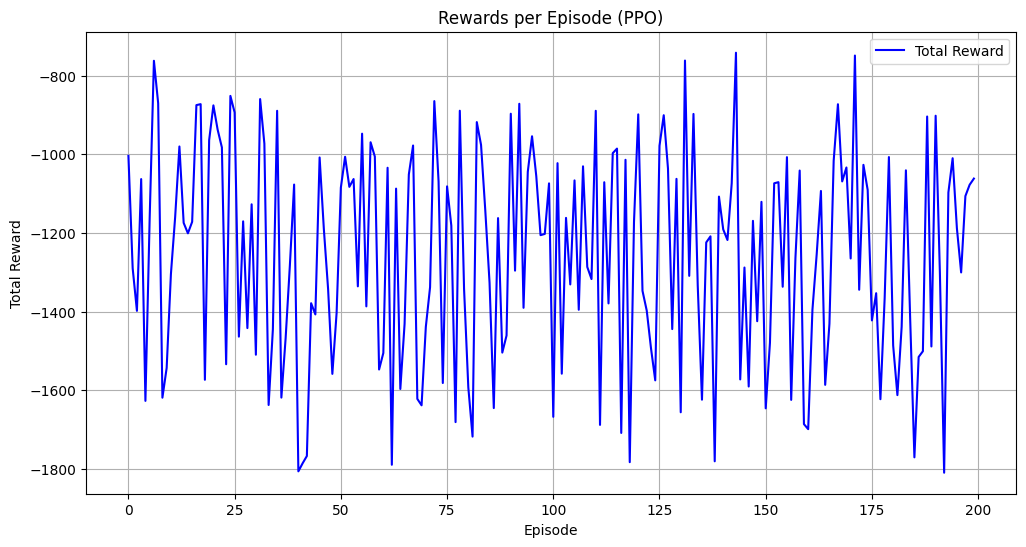

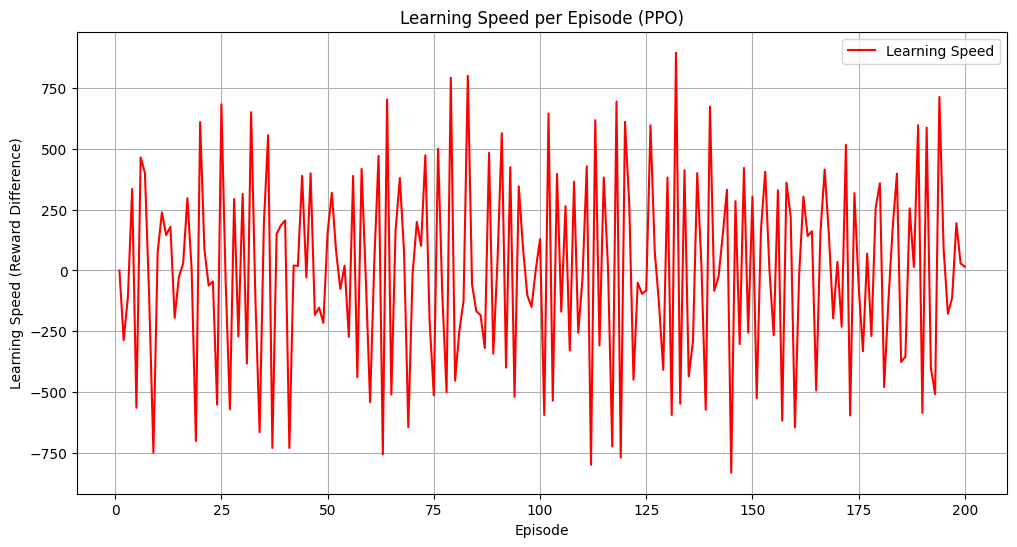

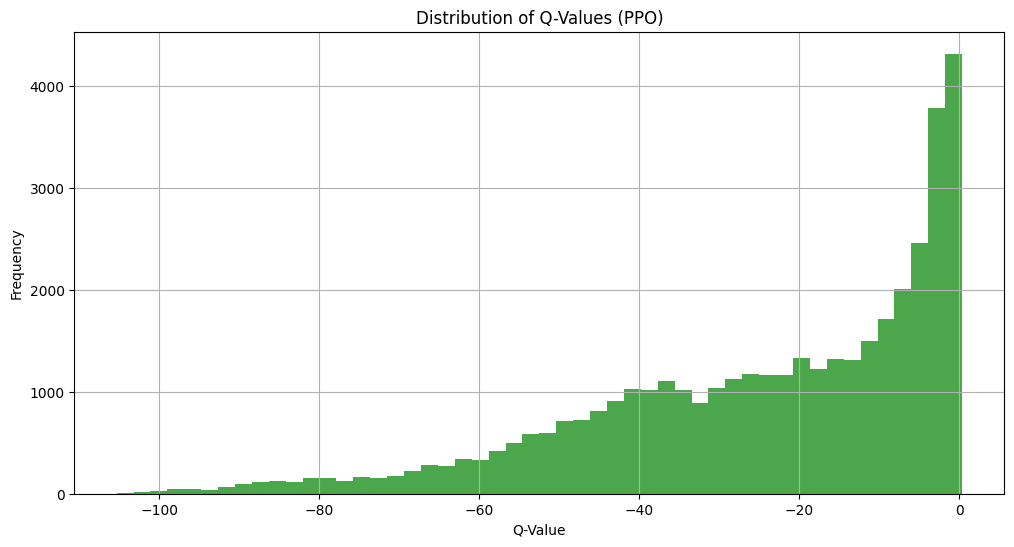

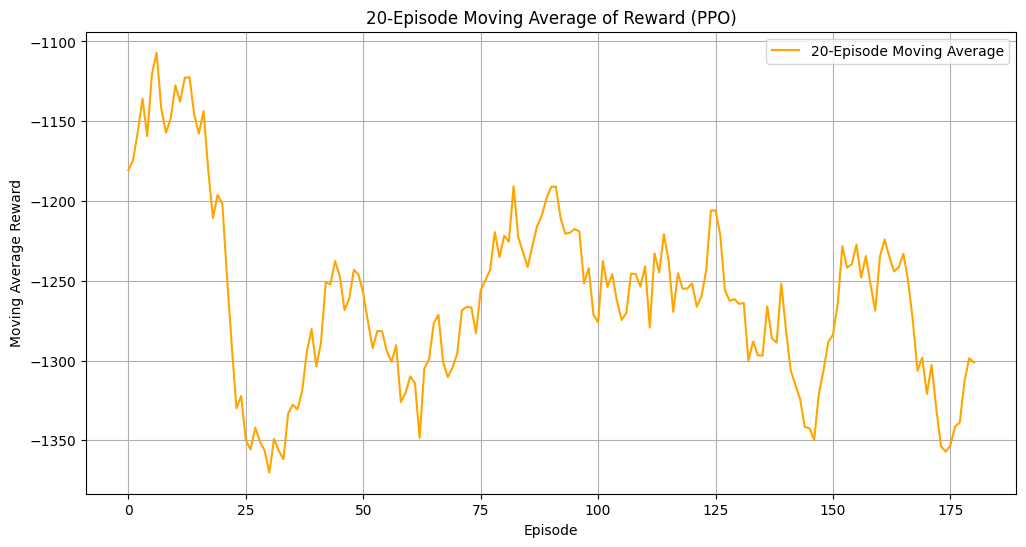

In [5]:
if __name__ == "__main__":
    STARTTIME = time.time()
    train_ppo()

## PPO Model Improvement

***

### `Improved_PPO` Class

The `Improved_PPO` class implements an enhanced Proximal Policy Optimization (PPO) algorithm for reinforcement learning. It includes the following features:

- **Initialization**:
  - Sets up policy and value networks with specified learning rates and hyperparameters.
  - Initializes a replay buffer with prioritized experience replay.

- **Methods**:
  - `build_model()`:
    - Creates the policy network.
  - `build_value_model()`:
    - Creates the value network.
  - `act(state)`:
    - Selects an action based on the policy network's output.
  - `compute_advantages(rewards, values, next_values, dones)`:
    - Calculates advantage estimates using Generalized Advantage Estimation (GAE).
  - `normalize_rewards(rewards)`:
    - Normalizes rewards to improve training stability.
  - `add_to_replay_buffer(state, action, reward, next_state, done)`:
    - Adds experience to the replay buffer with priority.
  - `sample_from_replay_buffer(batch_size)`:
    - Samples experiences from the replay buffer.
  - `update(states, actions, rewards, next_states, dones, weights, indices)`:
    - Updates the policy and value networks based on sampled experiences.
  - `decay_epsilon()`:
    - Decays the exploration rate (epsilon) over time.

This class combines PPO with prioritized experience replay to enhance learning efficiency and performance.


In [2]:
class Improved_PPO:
    def __init__(self, state_shape, n_actions, gamma=0.99, epsilon=0.2, lr=0.001, epsilon_decay=0.995, min_epsilon=0.01):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
        # Policy Network
        self.policy_model = self.build_model()
        self.policy_optimizer = Adam(learning_rate=self.lr)
        
        # Value Network
        self.value_model = self.build_value_model()
        self.value_optimizer = Adam(learning_rate=self.lr)
        
        # Q-value Network
        self.q_model = self.build_q_model()
        self.q_optimizer = Adam(learning_rate=self.lr)
        
        # Track learning speed and reward normalization
        self.prev_total_reward = None
        self.learning_speeds = []
        self.reward_mean = 0
        self.reward_std = 1

    def build_model(self):
        state_input = Input(shape=(self.state_shape,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.n_actions, activation='softmax')(x)
        model = Model(inputs=state_input, outputs=output)
        return model
    
    def build_value_model(self):
        state_input = Input(shape=(self.state_shape,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        output = Dense(1, activation='linear')(x)
        model = Model(inputs=state_input, outputs=output)
        return model
    
    def build_q_model(self):
        state_input = Input(shape=(self.state_shape,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.n_actions, activation='linear')(x)
        model = Model(inputs=state_input, outputs=output)
        return model
    
    def act(self, state):
        state = np.expand_dims(state, axis=0)
        prob = self.policy_model.predict(state)[0]
        return np.random.choice(self.n_actions, p=prob)
    
    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + (1 - dones[t]) * self.gamma * next_values[t] - values[t]
            gae = delta + (1 - dones[t]) * self.gamma * self.epsilon * gae
            advantages[t] = gae
        return advantages
    
    def compute_q_values(self, states, actions, rewards, next_states, dones):
        q_values = self.q_model.predict(states)
        next_q_values = self.q_model.predict(next_states)
        
        targets = rewards + self.gamma * np.max(next_q_values, axis=1) * (1 - dones)
        for i in range(len(actions)):
            q_values[i][actions[i]] = targets[i]
        
        return q_values

    def update(self, states, actions, rewards, next_states, dones):
        # Normalize rewards
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)
        
        values = self.value_model.predict(states)
        next_values = self.value_model.predict(next_states)
        
        advantages = self.compute_advantages(rewards, values, next_values, dones)
        q_values = self.compute_q_values(states, actions, rewards, next_states, dones)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        q_values = tf.convert_to_tensor(q_values, dtype=tf.float32)
        returns = advantages + values.flatten()

        # Update Policy Network
        with tf.GradientTape() as tape:
            probs = self.policy_model(states, training=True)
            actions_one_hot = tf.keras.utils.to_categorical(actions, self.n_actions)
            ratio = tf.reduce_sum(probs * actions_one_hot, axis=1) / tf.reduce_sum(self.policy_model(states) * actions_one_hot, axis=1)
            clipped_ratio = tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon)
            policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        
        policy_grads = tape.gradient(policy_loss, self.policy_model.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_model.trainable_variables))
        
        # Update Value Network
        with tf.GradientTape() as tape:
            value_preds = self.value_model(states)
            value_loss = tf.reduce_mean(tf.square(returns - value_preds))
        
        value_grads = tape.gradient(value_loss, self.value_model.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_model.trainable_variables))
        
        # Update Q-value Network
        with tf.GradientTape() as tape:
            q_preds = self.q_model(states)
            q_loss = tf.reduce_mean(tf.square(q_values - q_preds))
        
        q_grads = tape.gradient(q_loss, self.q_model.trainable_variables)
        self.q_optimizer.apply_gradients(zip(q_grads, self.q_model.trainable_variables))
        
        # Track learning speed
        if self.prev_total_reward is not None:
            reward_diff = np.sum(rewards) - self.prev_total_reward
            self.learning_speeds.append(reward_diff)
        else:
            self.learning_speeds.append(0)  # No difference for the first episode
        
        self.prev_total_reward = np.sum(rewards)
        
        # Decay epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)
        
        # Adaptive learning rate (Example: decrease learning rate if the loss is not improving)
        if len(self.learning_speeds) > 1 and self.learning_speeds[-1] < self.learning_speeds[-2]:
            self.lr *= 0.95
            self.policy_optimizer.learning_rate.assign(self.lr)
            self.value_optimizer.learning_rate.assign(self.lr)
            self.q_optimizer.learning_rate.assign(self.lr)

    def save_weights(self, policy_filepath, value_filepath, q_filepath):
        self.policy_model.save_weights(policy_filepath)
        self.value_model.save_weights(value_filepath)
        self.q_model.save_weights(q_filepath)
        print(f'Policy weights saved to {policy_filepath}')
        print(f'Value weights saved to {value_filepath}')
        print(f'Q-value weights saved to {q_filepath}')

In [3]:
class PendulumEnv:
    def __init__(self, EnvName='Pendulum-v0', NActions=40):
        self.env = gym.make(EnvName)
        self.NActions = NActions
        self.frames = []  # To store frames for GIF
    
    def PendulumActionConverter(self, A):
        ActualTorque = (A / self.NActions - 0.5) * 4
        return ActualTorque
    
    def PendulumInverseActionConverter(self, A):
        ActualA = round((A + 2) * (self.NActions - 1) / 4)
        return ActualA
    
    def OneEpisode(self, DQN, Epsilon, ShowEvery, episode):
        S = self.env.reset()
        ListOfRewards = []
        QValues = []  # Track Q-values for each step
        Done = False
        
        while not Done:
            self.frames.append(self.env.render(mode='rgb_array'))  # Capture frame
            
            Q = DQN.Main(S.reshape(-1, S.shape[0])).numpy()  # Convert tensor to numpy array
            QValues.append(Q.flatten())  # Save Q-values
            
            if np.random.rand() < Epsilon:
                AStep = self.env.action_space.sample()
                A = self.PendulumInverseActionConverter(AStep[0])
            else:
                A = np.argmax(Q)
                A = self.PendulumActionConverter(A)
                AStep = np.array([A])
                A = self.PendulumInverseActionConverter(A)
        
            if not episode % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
                self.env.render()
            
            SNext, R, Done, Info = self.env.step(AStep)
            DQN.UpdateReplayMemory((S, A, R, SNext, Done))
            DQN.Train(Done)
            ListOfRewards.append(R)
            
            if Done:
                self.env.close()
                TotalReward = np.sum(ListOfRewards)
                print(f'Episode {episode} finished with total reward: {TotalReward}')
                return TotalReward, QValues  # Return Q-values along with reward
            S = SNext
        
        # Limit frames to the last 50 episodes
        if len(self.frames) > 50 * self.env.spec.max_episode_steps:
            self.frames = self.frames[-50 * self.env.spec.max_episode_steps:]

### `Improved_PPO` Class Summary

The `Improved_PPO` class is an implementation of the Proximal Policy Optimization (PPO) algorithm with enhancements for improved performance. Key components include:

- **Replay Buffer**: Utilizes a prioritized experience replay buffer to store and sample transitions, enhancing learning efficiency.

- **PPO Agent**: Incorporates:
  - **Policy Network**: Learns the policy for action selection.
  - **Value Network**: Estimates the value function.

- **Training Process**:
  - **Experience Collection**: Gathers experiences by interacting with the environment.
  - **Replay Buffer Interaction**: Adds experiences to the buffer and samples from it for training.
  - **Network Updates**: Updates the policy and value networks based on sampled experiences.
  - **Advantage Computation**: Calculates advantages using Generalized Advantage Estimation (GAE).
  - **Reward Normalization**: Normalizes rewards to stabilize training.

- **Epsilon Decay**: Reduces exploration rate (epsilon) over time to balance exploration and exploitation.

This class enhances the traditional PPO algorithm by integrating prioritized experience replay and advanced reward normalization techniques, aiming to improve overall training performance and stability.


In [4]:
def train_ppo(env_name='Pendulum-v0', episodes=200, batch_size=64, show_every=10, save_gif=False, save_weights_path_policy='ppo_policy_weights.h5', save_weights_path_value='ppo_value_weights.h5', save_weights_path_q='ppo_q_weights.h5'):
    env = PendulumEnv(env_name)
    ppo = Improved_PPO(state_shape=env.env.observation_space.shape[0], n_actions=env.NActions)
    
    Rewards = []
    learning_speeds = []
    frames = []
    Q_values = []  # Track Q-values

    for episode in range(episodes):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        total_reward = 0
        
        state = env.env.reset()
        done = False
        while not done:
            action = ppo.act(state)
            actual_action = env.PendulumActionConverter(action)
            next_state, reward, done, _ = env.env.step([actual_action])
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            state = next_state
            total_reward += reward
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)
        
        ppo.update(states, actions, rewards, next_states, dones)
        
        Rewards.append(total_reward)
        
        # Calculate learning speed (reward difference)
        if episode > 0:
            learning_speed = Rewards[-1] - Rewards[-2]
            learning_speeds.append(learning_speed)
        else:
            learning_speeds.append(0)
        
        # Calculate average Q-value for the episode
        avg_q_value = np.mean(ppo.q_model.predict(states))
        Q_values.append(avg_q_value)

        print(f'Episode {episode+1} total reward: {total_reward}, average Q-value: {avg_q_value}')
        
        # Render the environment every `show_every` episodes
        if (episode + 1) % show_every == 0:
            frames.append(env.env.render(mode='rgb_array'))  # Capture frame
            env.env.render()
            print(f'Episode {episode+1} completed with total reward: {total_reward}')
        
        # Save weights at the end of training or at specified intervals
        if (episode + 1) % 50 == 0 or episode == episodes - 1:  # Example: Save every 50 episodes and at the end
            ppo.save_weights(save_weights_path_policy, save_weights_path_value, save_weights_path_q)
    
    env.env.close()
    
    # Plot Rewards per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(Rewards, color='b', label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode (Improved PPO)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Learning Speed per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(learning_speeds) + 1), learning_speeds, color='r', label='Learning Speed')
    plt.xlabel('Q')
    plt.ylabel('Learning Speed (Reward Difference)')
    plt.title('Learning Speed per Episode (Improved PPO)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Moving Average of Rewards
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    window_size = 20
    ma_rewards = moving_average(Rewards, window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(ma_rewards, label=f'{window_size}-Episode Moving Average', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title(f'{window_size}-Episode Moving Average of Reward (PPO)')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Q-values per Episode
    plt.figure(figsize=(12, 6))
    plt.plot(Q_values, color='g', label='Average Q-value')
    plt.xlabel('Episode')
    plt.ylabel('Q-value')
    plt.title('Distribution of Q-Values (Improved PPO)')
    plt.legend()
    plt.grid()
    plt.show()

    # Save GIF for the last 50 episodes if requested
    if save_gif and len(frames) > 0:
        with imageio.get_writer('Improved_ppo_training.gif', mode='I', duration=0.1) as writer:
            for frame in frames[-50:]:
                writer.append_data(frame)
    
    return Rewards, learning_speeds, Q_values

### Running the Training

Execute the `train_ppo` function to start training the Improved PPO model on the Pendulum environment.
***

7/7 [==============================] - 0s 984us/step
Episode 1 total reward: -1194.0886641549757, average Q-value: 0.028234444558620453
7/7 [==============================] - 0s 840us/step
Episode 2 total reward: -1086.7184849000146, average Q-value: 0.042491354048252106
7/7 [==============================] - 0s 1ms/step
Episode 3 total reward: -899.5576530067599, average Q-value: 0.01936168596148491
7/7 [==============================] - 0s 1ms/step
Episode 4 total reward: -1463.8945227005581, average Q-value: 0.032054927200078964
7/7 [==============================] - 0s 835us/step
Episode 5 total reward: -743.1223472420281, average Q-value: 0.05344667658209801
7/7 [==============================] - 0s 1ms/step
Episode 6 total reward: -1368.0344826868968, average Q-value: 0.04939943552017212
7/7 [==============================] - 0s 1ms/step
Episode 7 total reward: -855.6275709758817, average Q-value: 0.05129382014274597
7/7 [==============================] - 0s 835us/step
Episode 8 

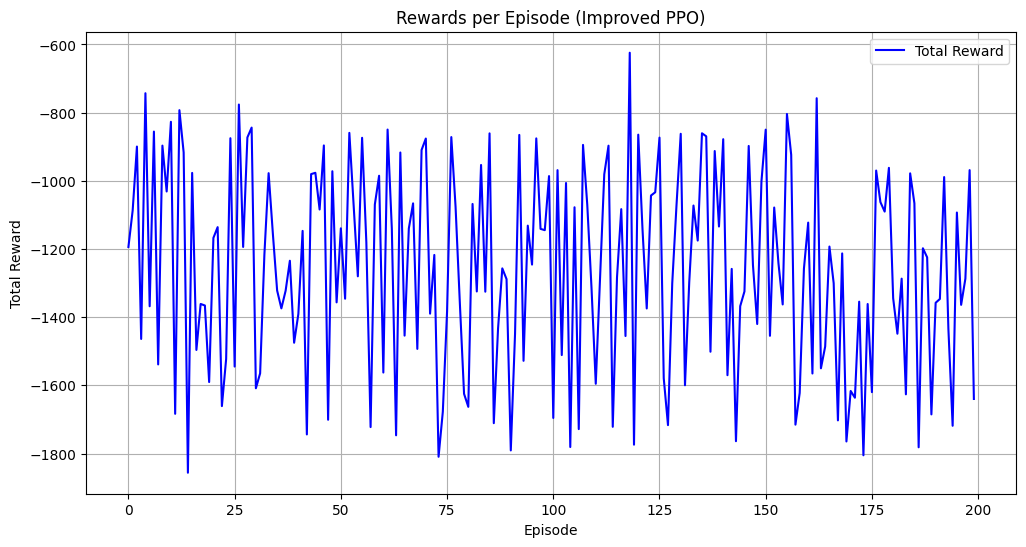

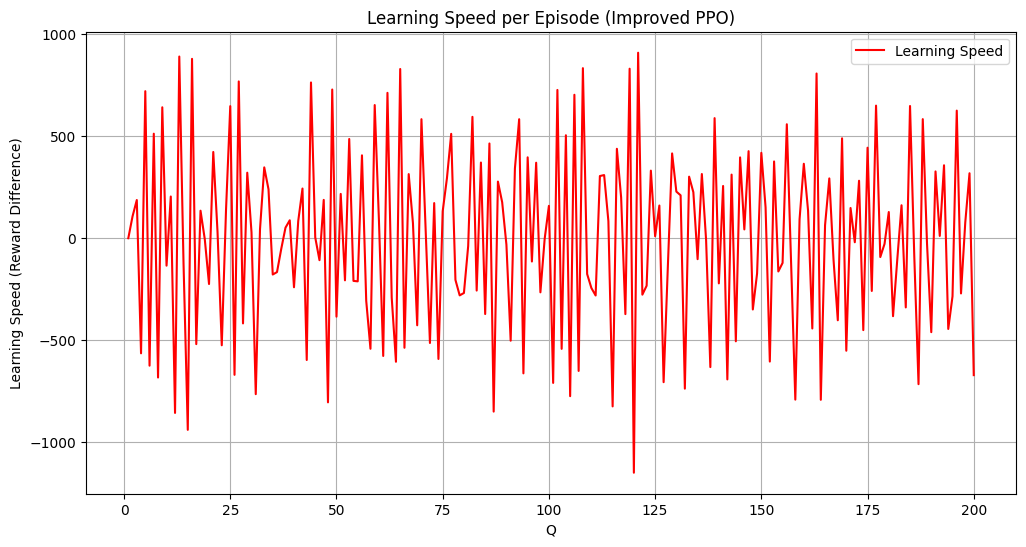

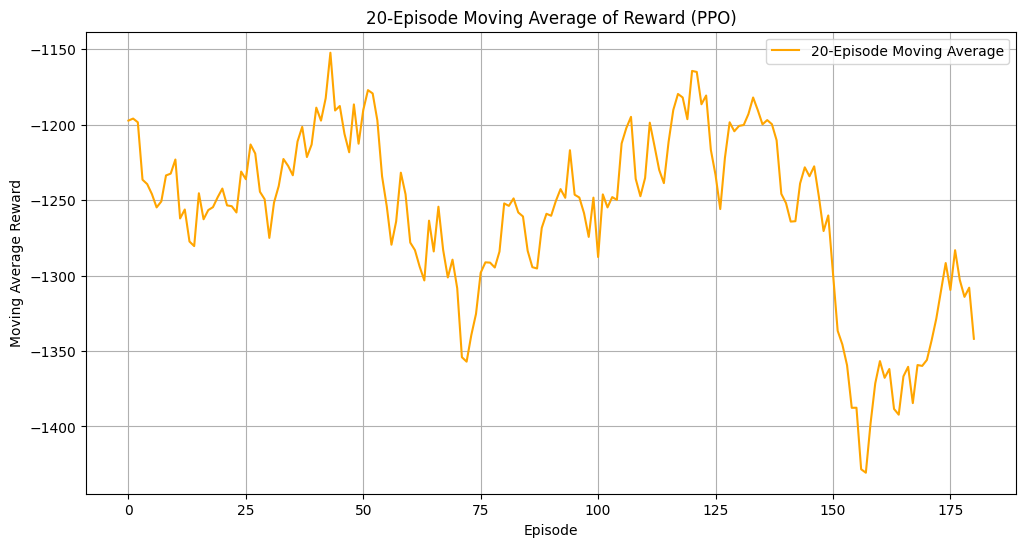

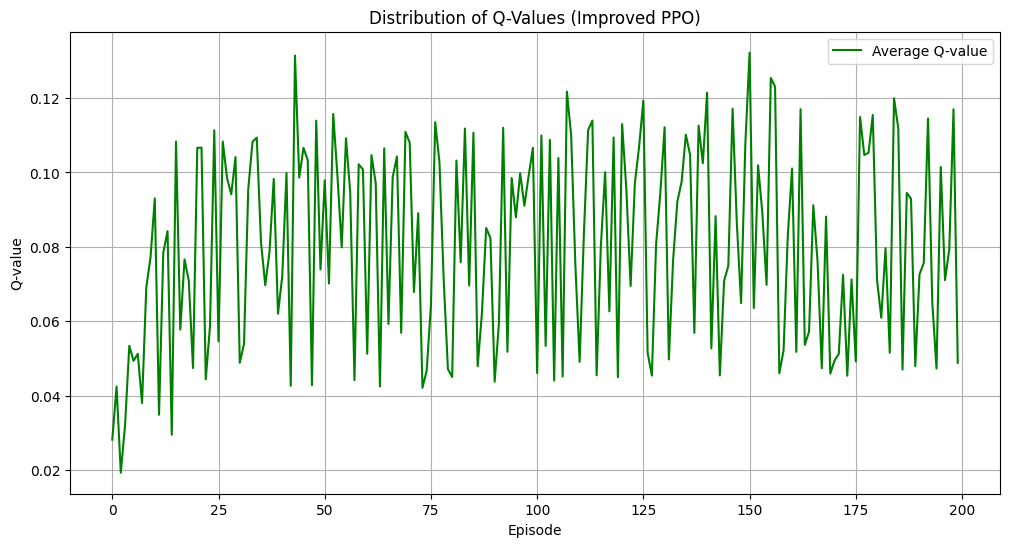

In [5]:
if __name__ == "__main__":
    STARTTIME = time.time()
    train_ppo(save_gif=True)
